<h1 align="center">Hotel booking demand prediction - Dự đoán nhu cầu đặt phòng khách sạn</h1>
<a id="0"></a> <br>

## Table of Contents  
1. [Khai báo thư viện và đọc dữ liệu từ file](#1)     
    1.1. [Khai báo các thư viện cần thiết](#1.1) <br> 
    1.2. [Giải thích thuộc tính thuộc tính](#1.2) 
2. [Làm sạch dữ liệu và chia tập dữ liệu (train và test)](#2) <br>
    2.1. [Xoá dữ liệu bị duplicated (nếu có)](#2.1)<br>
    2.2. [Chia tập train và tập test](#2.2) <br>
    2.3. [Xử lý missing value](#2.3) <br>
    2.4. [Xoá các quan sát không có ý nghĩa](#2.4)<br>
3. [Exploratory Data Analysis - Phân tích dữ liệu khám phá](#3) 
4. [Tiền xử lý dữ liệu](#4)     
    4.1. [Remove target column](#4.1) 
5. [Huấn luyện mô hình và dự đoán](#5)     


<a id='1'></a>
# 1. Khai báo thư viện và đọc dữ liệu từ file

<a id='1.1'></a>
## 1.1 Khai báo các thư viện cần thiết 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

In [2]:
hotel_booking = pd.read_csv("data/hotel_bookings.csv")
hotel_booking.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
hotel_booking.shape

(119390, 32)

<a id='1.2'></a>
## 1.2 Giải thích các thuộc tính

In [4]:
hotel_booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

**Thuộc tính**

- **`hotel`**: biến target, 
- **`is_canceled`**: trạng thái đặt phòng có bị huỷ, 1 là đã huỷ, 0 là chưa huỷ (*categorical*).
- **`lead_time`**: Số ngày trôi qua kể từ ngày nhập đặt phòng vào PMS và ngày đến.
- **`arrival_date_week_number`**: 
- **`is_repeated_guest`**: một khách có đặt nhiều lần.
- **`previous_cancellations`**: số lần đặt trước bị huỷ trước lần đặt hiện tại của khách hàng.
- **`previous_bookings_not_canceled`**: số lần đặt trước không bị huỷ trước lần đặt hiện tại của khách hàng.
- **`reservation_status`**: trạng thái đặt phòng cuối cùng (Canceled: đã huỷ, Check-Out: khách hàng đã checkin nhưng đã rời đi, No-Show: đặt nhưng ko nhận phòng)
- **`reservation_status_date`**: Ngày mà trạng thái cuối cùng được thiết lập. Biến này có thể được sử dụng cùng với *Reservation_Status* để hiểu khi nào đặt phòng bị hủy hoặc khi nào khách hàng trả phòng khách sạn.
- **`market_segment`**: Phân khúc thị trường. “TA”: Đại lý Du lịch, “TO”: Nhà điều hành Tour.
- **`adults`**: Số lượng người lớn.
- **`babies`**: Số lượng trẻ sơ sinh.
- **`children`**: Số lượng trẻ em.
- **`distribution_channel`**: Kênh phân phối đặt phòng ( 

<a id='2'></a>
# 2. Làm sạch dữ liệu và chia tập dữ liệu (train và test)

<a id='2.1'></a>
## 2.1 Xoá dữ liệu bị duplicated (nếu có)

In [5]:
hotel_booking = hotel_booking.drop_duplicates()
hotel_booking.shape

(87396, 32)

Dữ liệu sau khi xoá `duplicated` từ `119390` còn `87396` quan sát. <br> <br>
Để tránh việc chúng ta quan sát và phân tích đến tập test thì ta sẽ chia tập train và test trước khi làm xử dữ liệu và phân tích.

<a id='2.2'></a>
## 2.2 Chia tập train và tập test

In [6]:
df_train_input = hotel_booking.drop(columns='is_canceled')
df_train_output = hotel_booking['is_canceled']

In [7]:
df_train_output.value_counts().to_frame()

,is_canceled
0,63371
1,24025


In [8]:
train_input, test_input, train_output, test_output = train_test_split(
    df_train_input,
    df_train_output,
    test_size=0.3,
    stratify=df_train_output,
    random_state=0
)

In [9]:
train_input.shape

(61177, 31)

In [10]:
train_output.shape

(61177,)

In [11]:
test_input.shape

(26219, 31)

<a id='2.3'></a>
## 2.3 Xử lý missing value

In [12]:
def display_missing(df):
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            print(f"{col:} {missing_count} missing values, {missing_count*100/df.shape[0]:.3f}%. ")

display_missing(train_input),print('\n')
display_missing(test_input)

children 4 missing values, 0.007%. 
country 306 missing values, 0.500%. 
agent 8555 missing values, 13.984%. 
company 57482 missing values, 93.960%. 


country 146 missing values, 0.557%. 
agent 3638 missing values, 13.875%. 
company 24655 missing values, 94.035%. 


#### **Xoá cột `company` vì số lượng giá trị `na` quá lớn** 

In [13]:
train_input = train_input.drop(columns=["company"])
test_input = test_input.drop(columns=["company"])

In [14]:
train_input.shape

(61177, 30)

#### Điền các dòng có giá trị `na` ở cột `children` và `country`
- Vì các cột `children` và `country` đều có kiểu dữ liệu categorical nên ta sẽ điền missing bằng giá trị xuất hiện nhiều nhất tương ứng ở các cột `children` và `country` trong tập dữ liệu.

In [15]:
train_input = train_input.apply(lambda x: x.fillna(x.value_counts().index[0]))
test_input = test_input.apply(lambda x: x.fillna(x.value_counts().index[0]))

<a id='2.4'></a>
## 2.4 Xoá các quan sát không có ý nghĩa
- Thuộc tính `adults` không thể có giá trị là 0. Vì bài toán đang giải quyết liên quan đến booking thì việc booking sẽ  phải có người lớn tham gia. 

In [16]:
train_input = train_input[~(train_input['adults'] == 0)]
train_output = train_output[train_input.index]

test_input = test_input[~(test_input['adults'] == 0)]
test_output = test_output[test_input.index]

In [17]:
train_input.shape

(60918, 30)

In [18]:
test_input.shape

(26093, 30)

<a id='3'></a>
# 3. Exploratory Data Analysis - Phân tích dữ liệu khám phá

## Các cột có kiểu dữ liệu categorical

In [19]:
# tạo tập dữ liệu copy từ tập train_input
train_input_cp = train_input.copy()

In [20]:
# danh sách các thuộc tính categorical
categorical_features = ['hotel', 'arrival_date_year', 'arrival_date_month', 'stays_in_weekend_nights',
                        'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country',
                        'arrival_date_day_of_month', 'market_segment', 'distribution_channel', 'is_repeated_guest',
                        'previous_cancellations', 'reserved_room_type', 'assigned_room_type', 'booking_changes',
                        'deposit_type', 'customer_type', 'required_car_parking_spaces', 'total_of_special_requests',
                        'reservation_status']
train_input_cp[categorical_features] = train_input_cp[categorical_features].astype('category')

print('numbers category:',len(categorical_features))

numbers category: 23


## Các cột có kiểu dữ liệu numeric

In [21]:
# Danh sách các thuộc tính numeric
numerical_features = ['lead_time', 'adr', 'agent', 'days_in_waiting_list', 
                      'arrival_date_week_number', 'previous_bookings_not_canceled']
print('numbers numeric: ', len(numerical_features))

numbers numeric:  6


## Quan sát các cột có kiểu dữ liệu categotical

In [22]:
train_input_cp.describe(include=['category'])

,hotel,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,...,is_repeated_guest,previous_cancellations,reserved_room_type,assigned_room_type,booking_changes,deposit_type,customer_type,required_car_parking_spaces,total_of_special_requests,reservation_status
count,60918,60918,60918,60918,60918,60918,60918,60918.0,60918,60918,...,60918,60918,60918,60918,60918,60918,60918,60918,60918,60918
unique,2,3,12,31,17,32,12,5.0,5,5,...,2,13,9,11,18,3,4,5,6,3
top,City Hotel,2016,August,2,0,1,2,0.0,0,BB,...,0,0,A,A,0,No Deposit,Transient,0,0,Check-Out
freq,37133,29506,7828,2137,24567,15495,45187,55203.0,60297,47328,...,58539,59745,39542,32336,49902,60124,50245,55772,30635,44165


In [23]:
train_input_cp.describe()

,lead_time,arrival_date_week_number,previous_bookings_not_canceled,agent,days_in_waiting_list,adr
count,60918.000000,60918.000000,60918.000000,60918.000000,60918.000000,60918.000000
mean,79.799353,26.854723,0.181654,82.729062,0.743820,106.642589
std,85.907500,13.661320,1.704829,109.282684,10.056465,56.111931
min,0.000000,1.000000,0.000000,1.000000,0.000000,-6.380000
25%,11.000000,16.000000,0.000000,9.000000,0.000000,72.240000
50%,49.000000,27.000000,0.000000,9.000000,0.000000,98.100000
75%,125.000000,37.000000,0.000000,240.000000,0.000000,134.300000
max,737.000000,53.000000,72.000000,535.000000,391.000000,5400.000000


## Quan sát phân phối của các cột có kiểu dữ liệu numerical

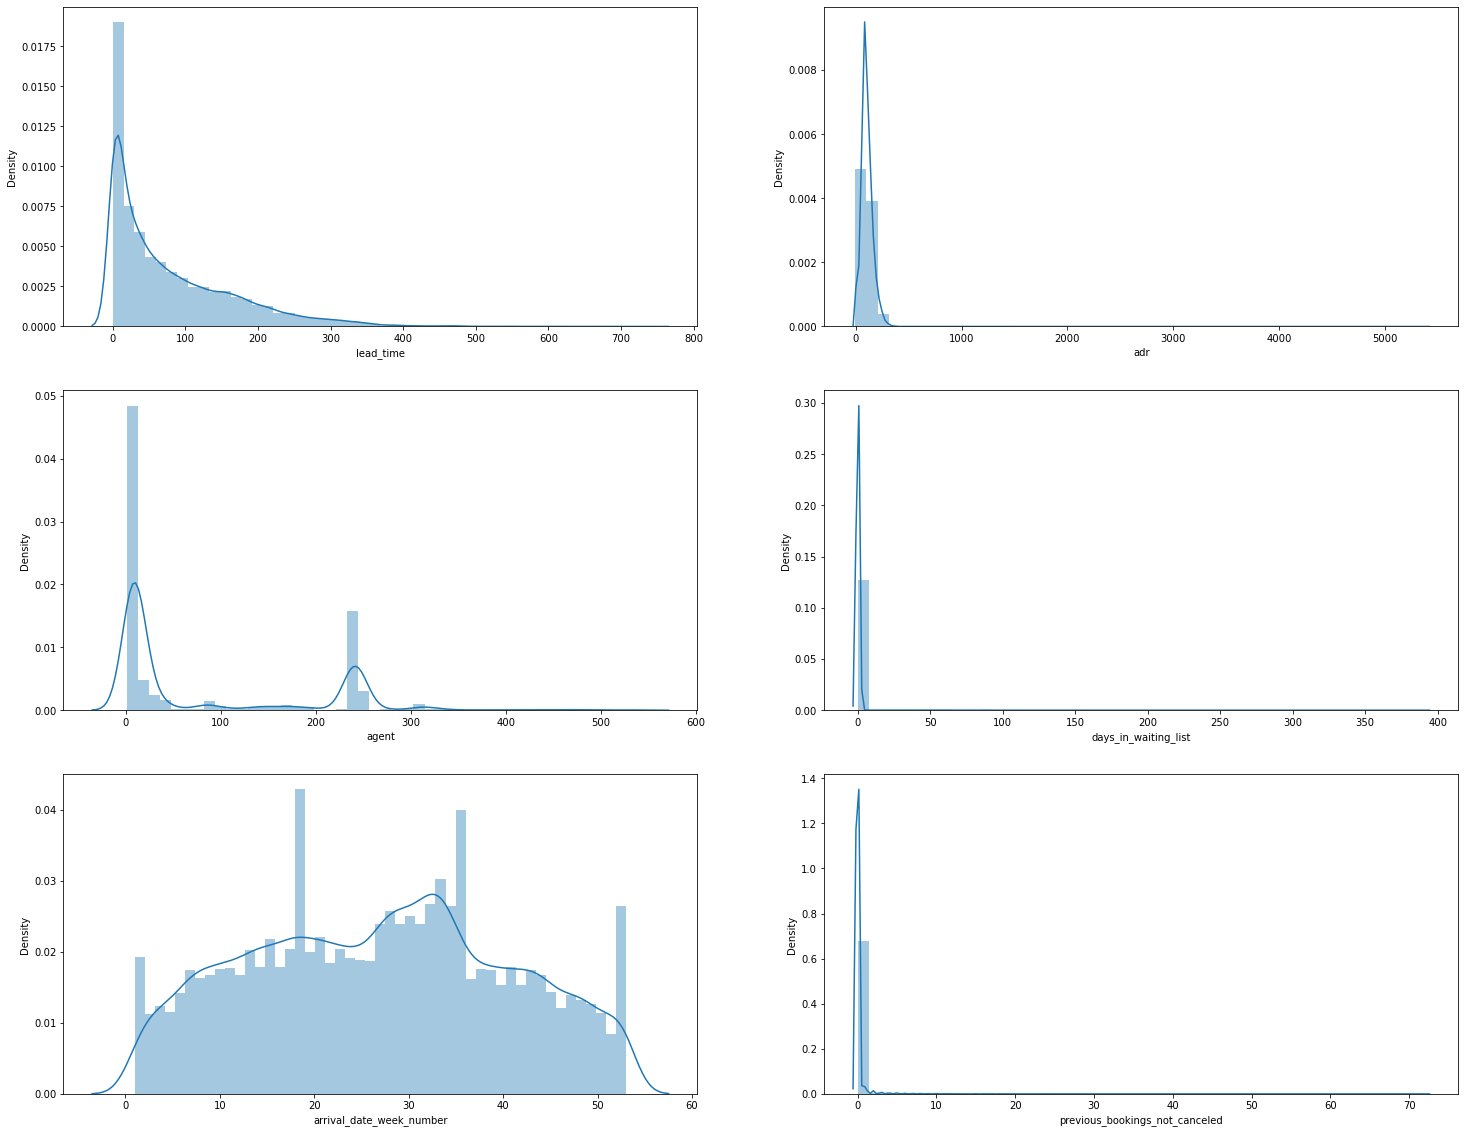

In [24]:
# Sử dụng đồ thị quan sát phân phối của các thuộc tính numeric
plt.figure(figsize=(25,20), facecolor='white')
plotnumber = 1
for numerical_feature in numerical_features:
    ax = plt.subplot(3, 2, plotnumber)
    sns.distplot(train_input_cp[numerical_feature])
    plt.xlabel(numerical_feature)
    plotnumber+=1
plt.show()

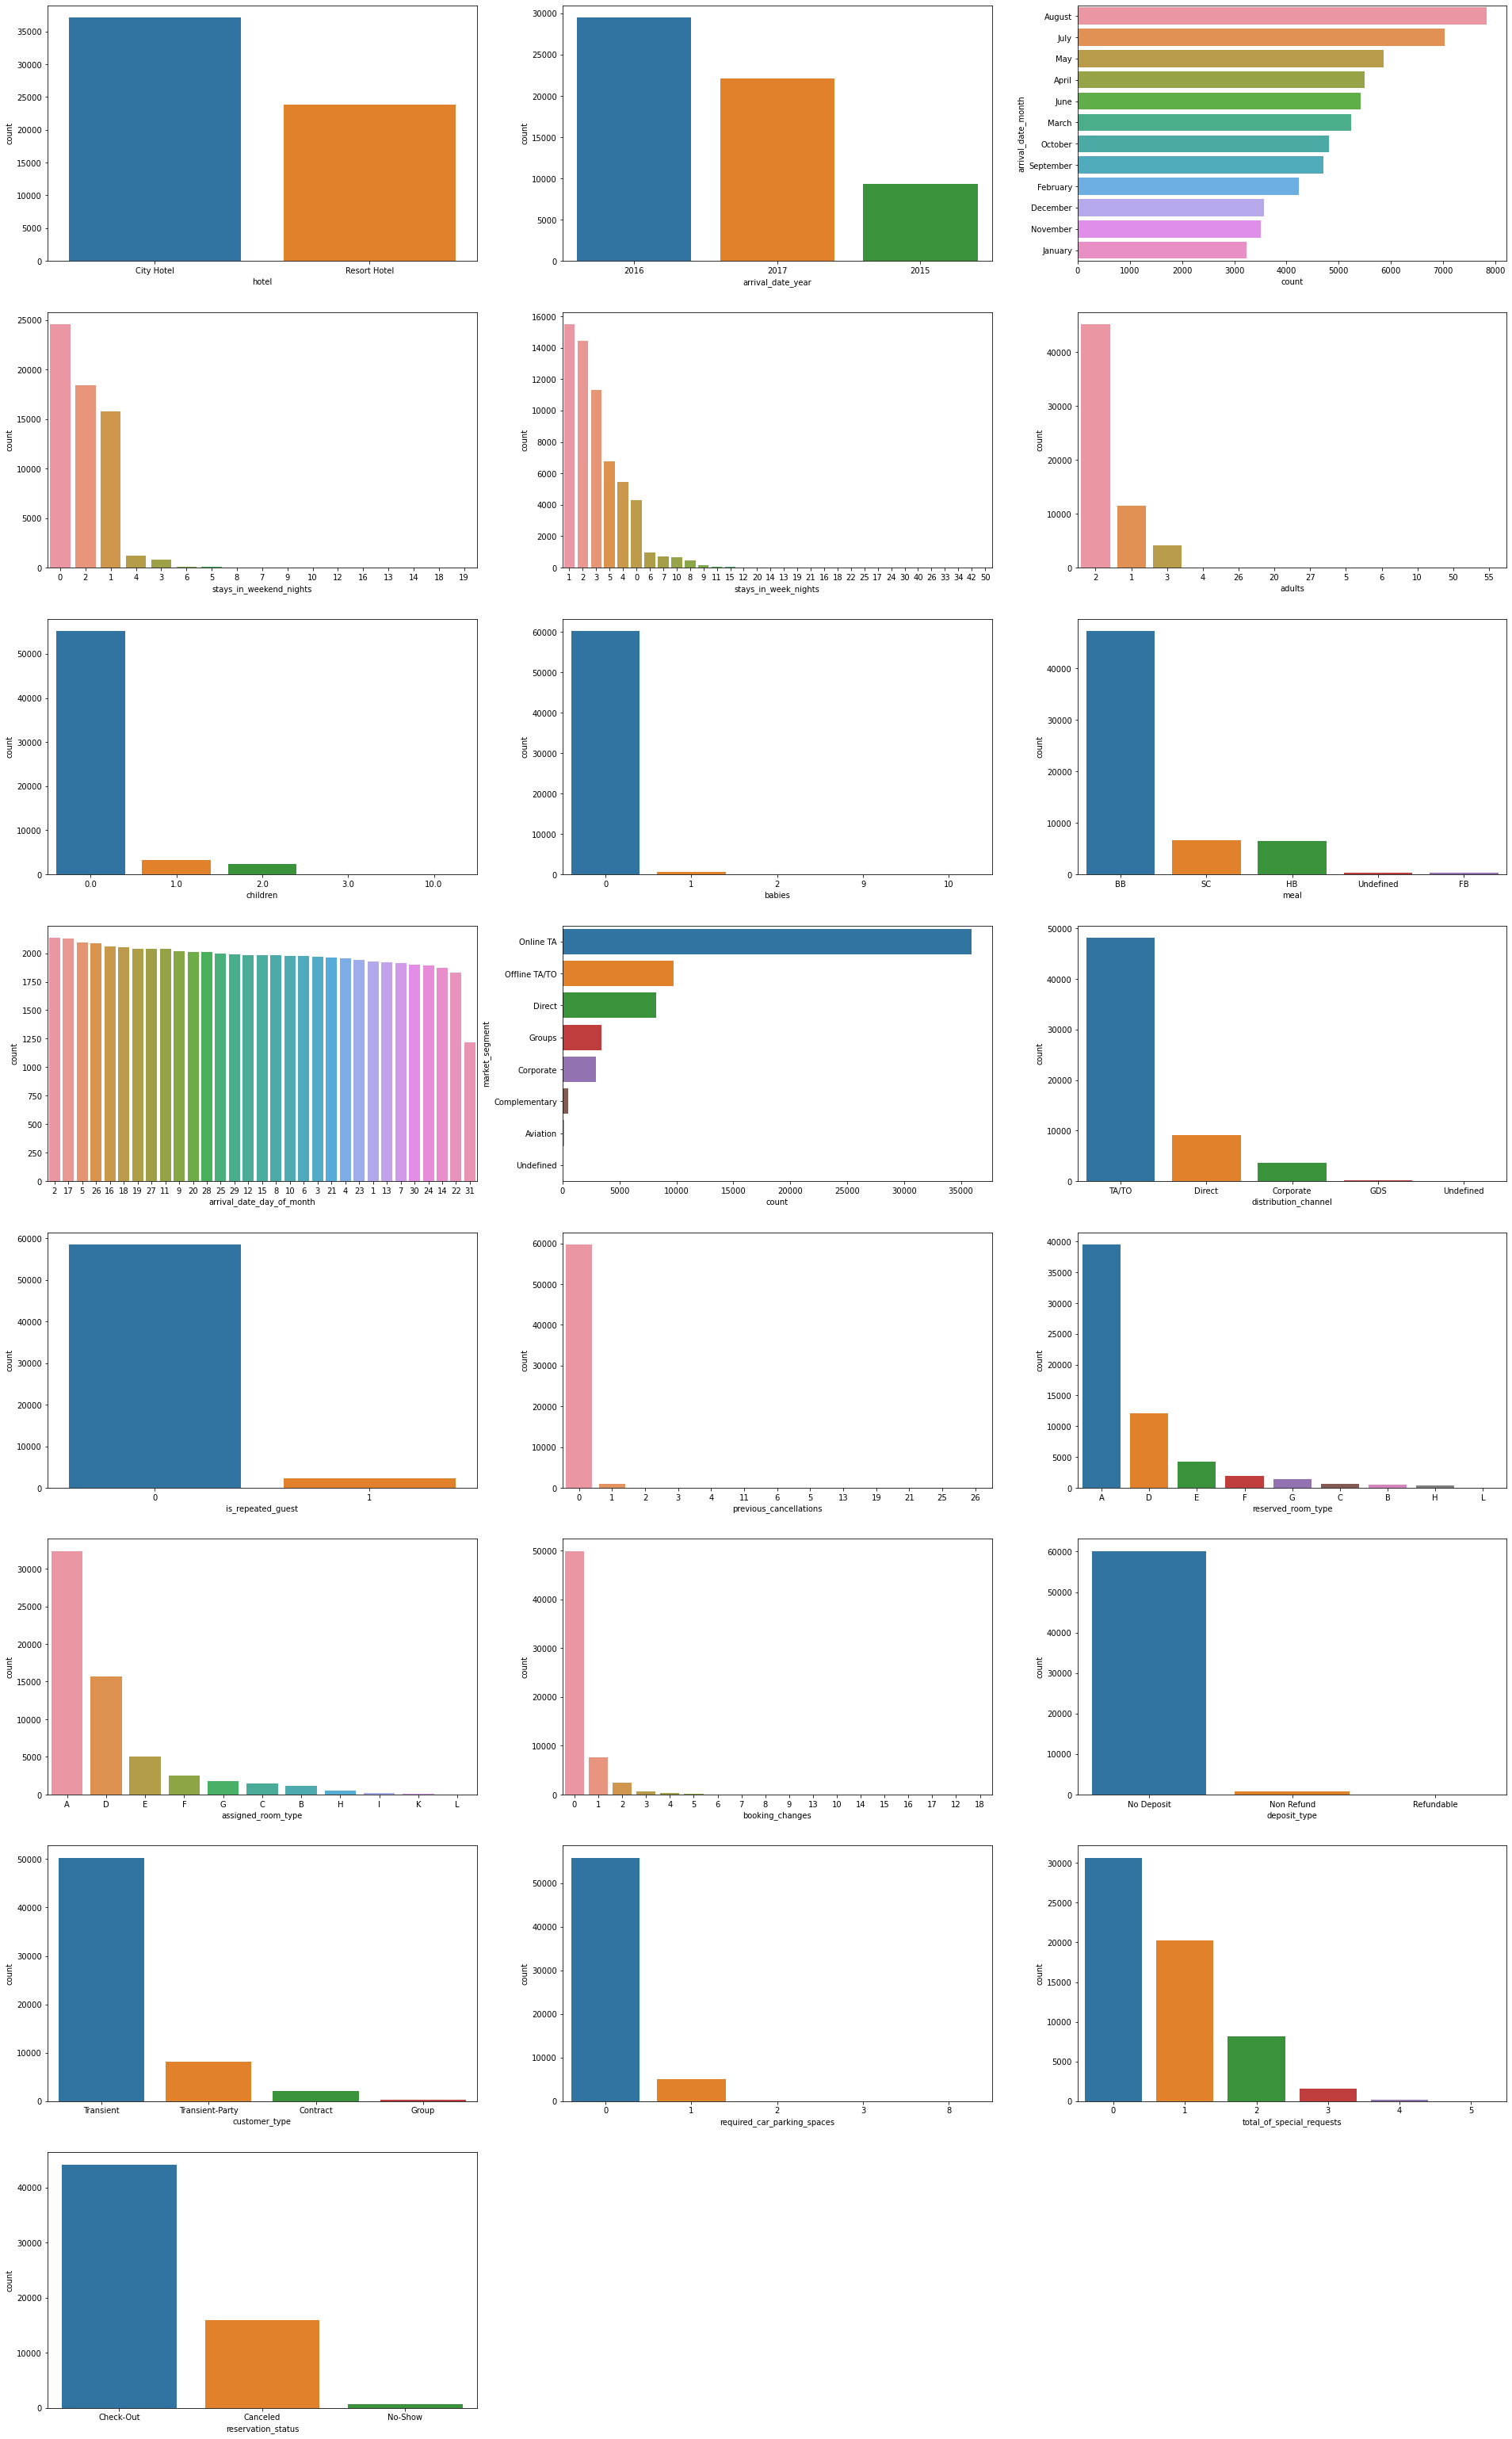

In [25]:
# Số lượng phân loại cụ thể của các thuộc tính categorical  
plt.figure(figsize=(33,70), facecolor='white')
plotnumber = 1 
for categorical_feature in categorical_features:
    ax = plt.subplot(10,3, plotnumber)
    if categorical_feature != 'country':
        if categorical_feature == 'arrival_date_month' or categorical_feature == 'market_segment':
            sns.countplot(y=categorical_feature
                          , data=train_input_cp
                          , order=train_input_cp[categorical_feature].value_counts().index)
            plt.ylabel(categorical_feature)

        else:
            sns.countplot(x=categorical_feature
                          , data=train_input_cp
                          , order=train_input_cp[categorical_feature].value_counts().index)
            plt.xlabel(categorical_feature)
        plotnumber += 1
plt.show()

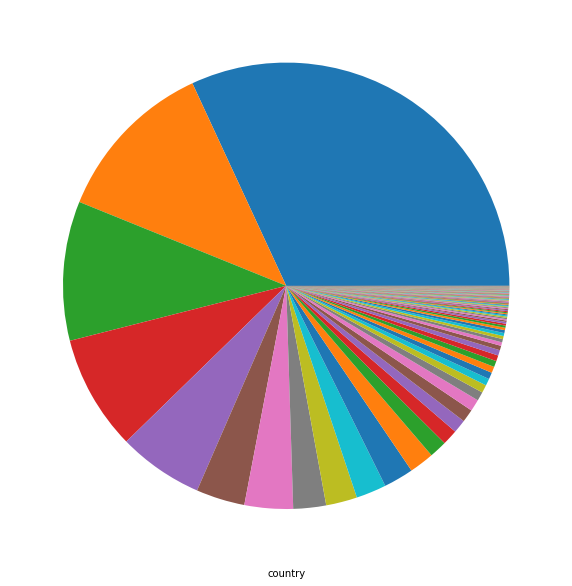

In [26]:
# Số lượng phân loại cụ thể của các thuộc tính categorical
plt.figure(figsize=(10,20), facecolor='white')
plt.pie(x=train_input_cp['country'].value_counts(), data=train_input_cp)
plt.xlabel('country');

**Nhận xét:** Các cột *'babies', 'is_repeated_guest', 'previous_cancellations', 'deposit_type', 'previous_booking_not_canceled', 'days_in_waiting_list'* có sự thiên lệch khá lớn về số lượng quan sát ở một giá trị phân loại so với các giá trị phân loại còn lại. 

In [27]:
train_input_concat = pd.concat([train_input, train_output], axis=1)
train_input_concat.shape

(60918, 31)

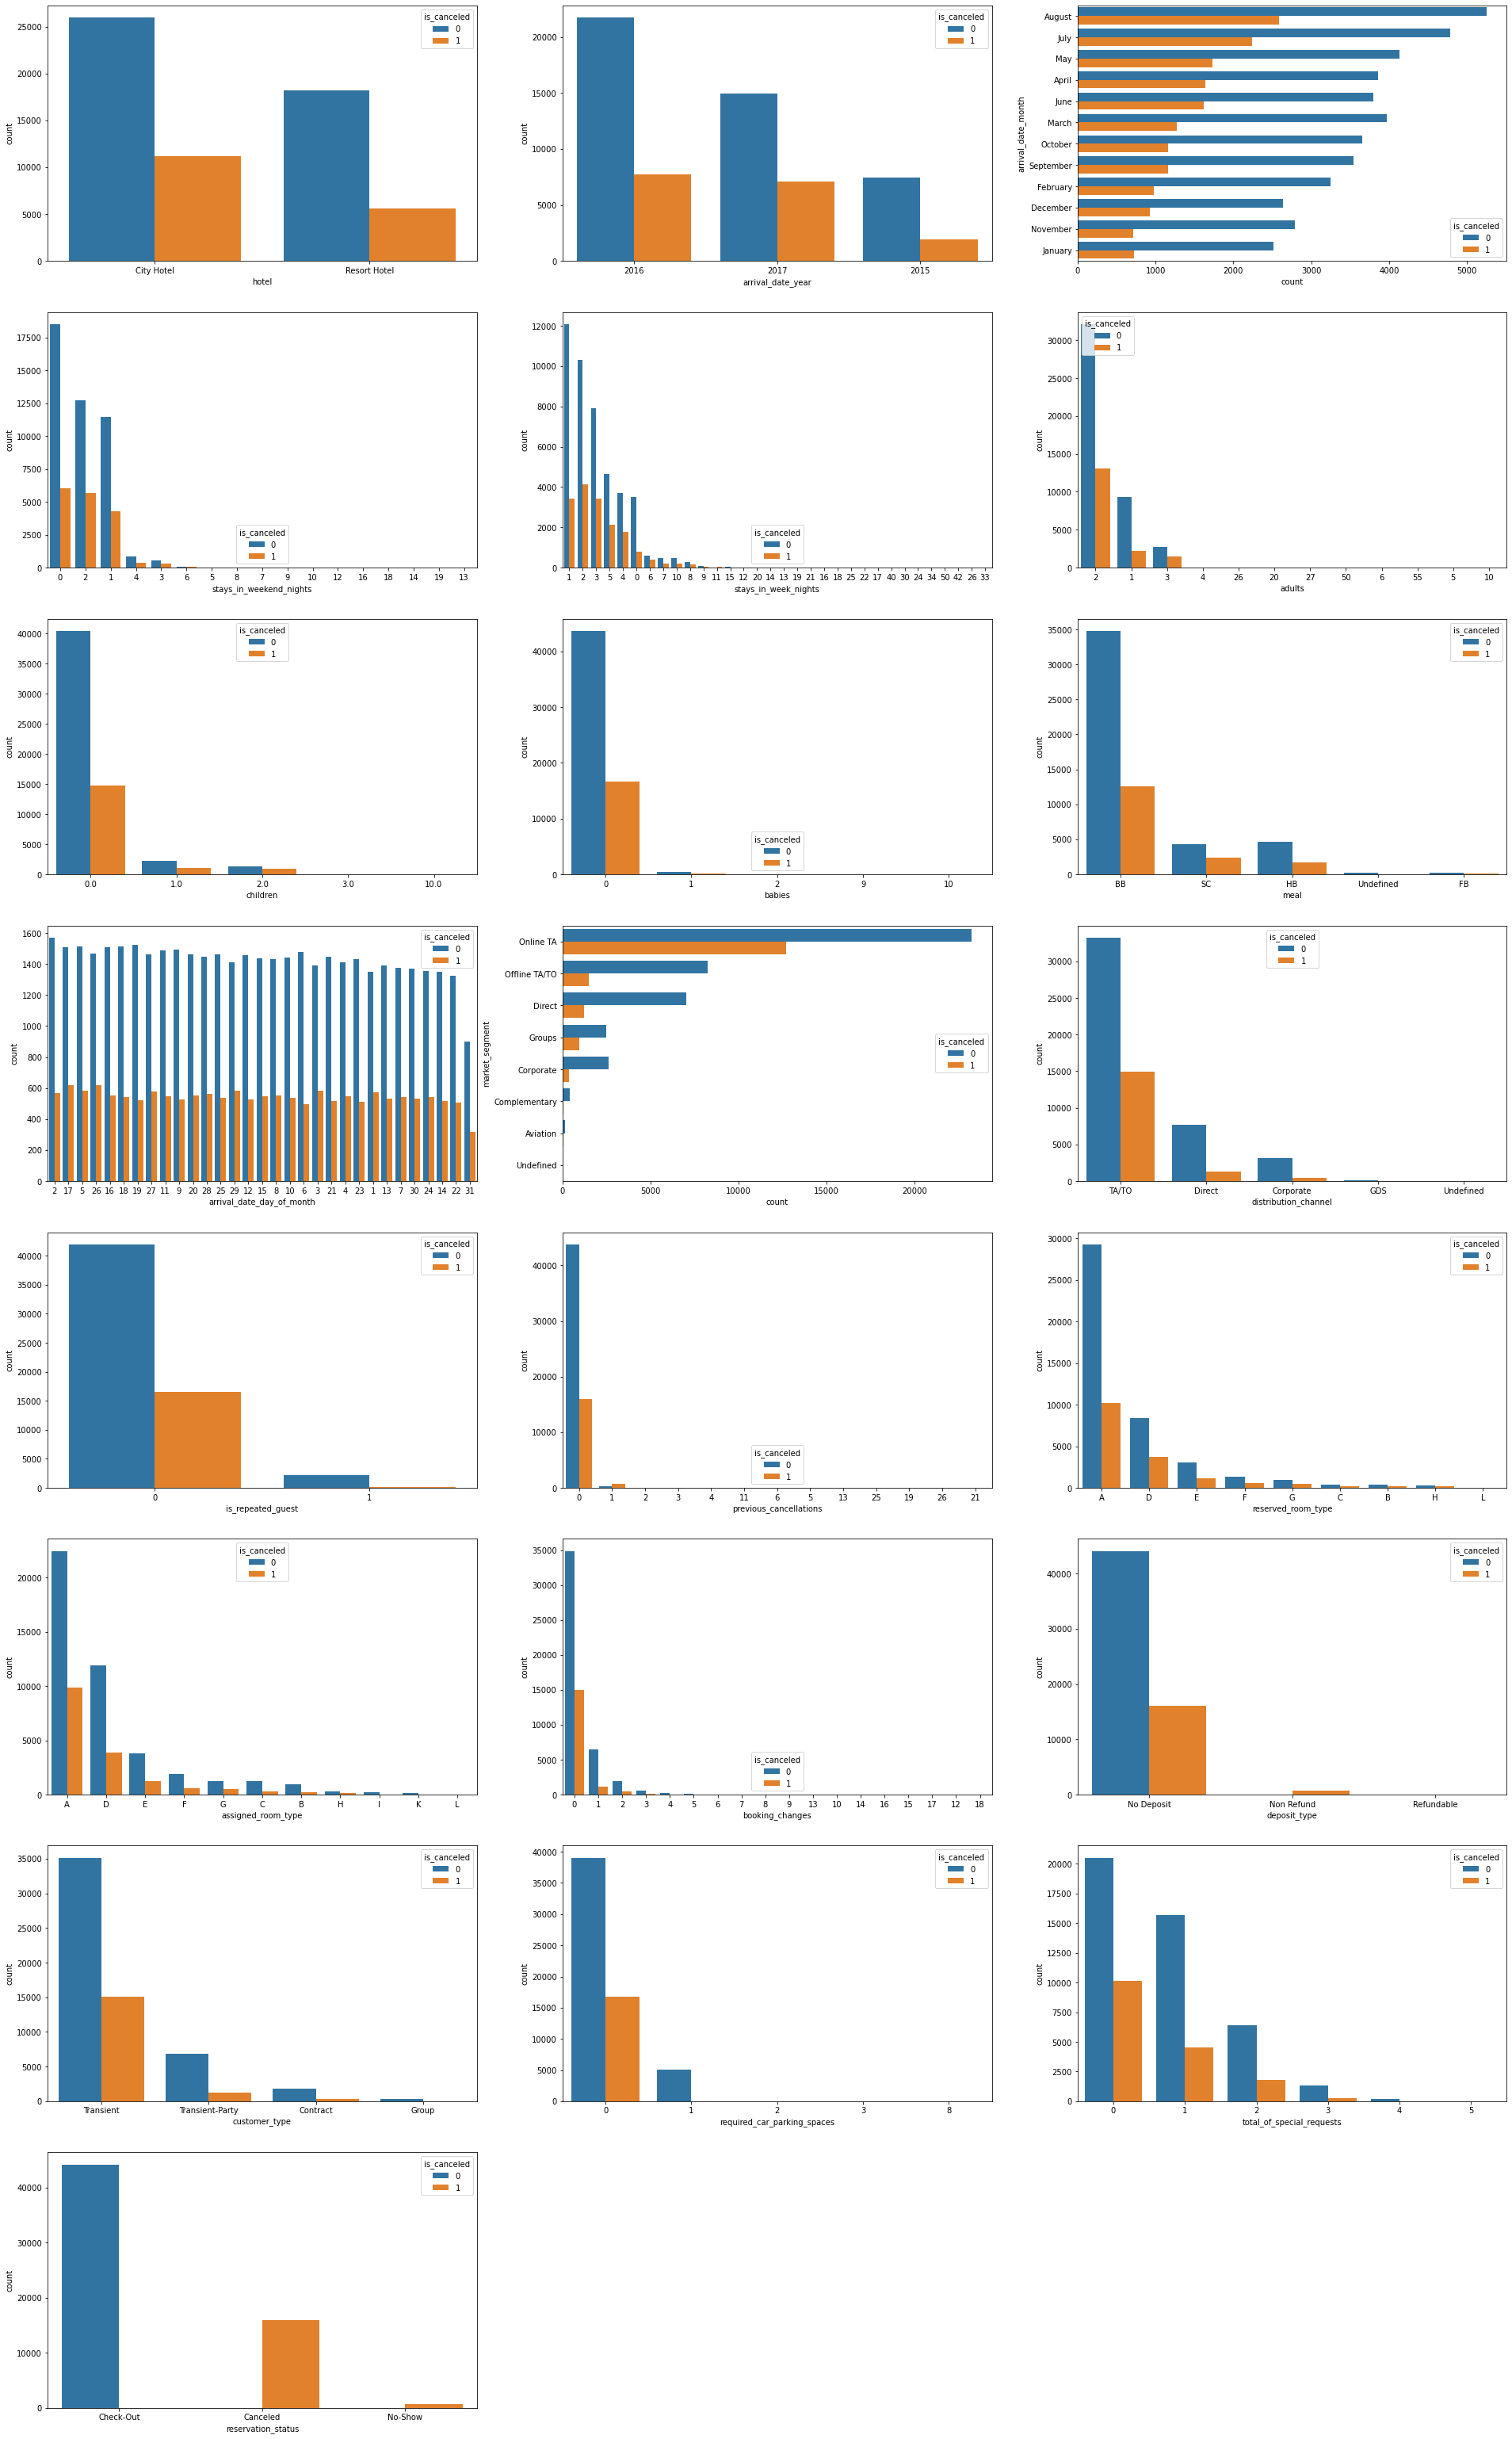

In [28]:
plt.figure(figsize=(33,70), facecolor='white')
plotnumber = 1 
for categorical_feature in categorical_features:
    ax = plt.subplot(10,3, plotnumber)
    if categorical_feature != 'country':
        if categorical_feature == 'arrival_date_month' or categorical_feature == 'market_segment':
            sns.countplot(y=categorical_feature
                          , data=train_input_concat
                          , order=train_input_concat[categorical_feature].value_counts().index
                          , hue='is_canceled')
            plt.ylabel(categorical_feature)
        else:
            sns.countplot(x=categorical_feature
                          , data=train_input_concat
                          , order=train_input_concat[categorical_feature].value_counts().index
                          , hue='is_canceled')
            plt.xlabel(categorical_feature)
        plotnumber += 1
plt.show()

**Nhận xét:** 2 biến 'is_canceled' và 'reservation_status' có sự phụ thuộc tuyến tính mạnh vs nhau. Nếu trạng thái là đã huỷ đặt chỗ ('is_canceled' = 1 thì đồng nghĩa vs giá trị của biến 'reservation_status' là 'Canceled' hoặc 'No-Show' và cũng đúng với 'is_canceled' = 0)

In [29]:
s = 0
for i in train_input['country'].value_counts().values:
    if i < 500:
        s += i
print(train_input['country'].value_counts().values)
print(s)

[19436  7291  6147  5074  3758  2150  2138  1445  1374  1334  1319  1095
   775   680   589   569   522   392   349   304   297   275   268   257
   241   196   158   144   136   134   129   105    96    82    80    61
    60    57    56    52    47    46    46    46    45    44    43    38
    34    33    33    31    30    30    30    28    24    24    23    22
    21    20    19    19    18    18    18    16    16    15    14    14
    14    14    13    13    12    12    12    12    12    11    10    10
    10     9     9     8     8     8     8     7     6     6     6     6
     6     6     5     5     5     5     4     4     4     4     3     3
     3     3     3     3     3     3     3     3     3     3     2     2
     2     2     2     2     2     2     2     2     2     2     2     2
     2     2     2     2     2     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1   

In [30]:
train_input['country'].value_counts().head(20)

PRT    19436
GBR     7291
FRA     6147
ESP     5074
DEU     3758
ITA     2150
IRL     2138
BEL     1445
BRA     1374
NLD     1334
USA     1319
CHE     1095
CN       775
AUT      680
SWE      589
CHN      569
POL      522
RUS      392
NOR      349
ROU      304
Name: country, dtype: int64

In [31]:
# Group country với các giá trị xuất hiện ít
def group_country(country):
    if country in ['PRT', 'GBR', 'FRA', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'BRA', 'NLD', 'USA', 'CHE']:
        return country
    else:
        return 'Others'

train_input['country'] = train_input['country'].apply(lambda country: group_country(country))
test_input['country'] = test_input['country'].apply(lambda country: group_country(country))

In [32]:
train_input['country'].value_counts()

PRT       19436
Others     8357
GBR        7291
FRA        6147
ESP        5074
DEU        3758
ITA        2150
IRL        2138
BEL        1445
BRA        1374
NLD        1334
USA        1319
CHE        1095
Name: country, dtype: int64

Text(0.5, 0, 'country')

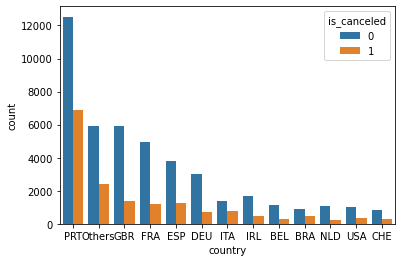

In [33]:
sns.countplot(x='country'\
                          , data=train_input\
                          , order=train_input['country'].value_counts().index\
                          , hue=train_output)
plt.xlabel('country')

In [34]:
train_input_concat.groupby(['is_canceled', 'previous_cancellations'])['previous_cancellations'].count()

is_canceled  previous_cancellations
0            0                         43792
             1                           237
             2                            50
             3                            31
             4                            17
             5                            10
             6                            11
             11                           16
             13                            1
1            0                         15953
             1                           748
             2                            26
             3                            13
             4                             3
             5                             1
             6                             1
             11                            2
             13                            2
             19                            1
             21                            1
             25                            1
             26    

In [35]:
train_input_concat['prev_cancellations_cat'] = pd.cut(train_input_concat['previous_cancellations'],
                                                    bins=[0,1,2,12,27], labels=['0', '1', '2-11', '12-26'],
                                                    right=False)

In [36]:
train_input_concat.groupby(['is_canceled', 'prev_cancellations_cat'])['prev_cancellations_cat'].count()

is_canceled  prev_cancellations_cat
0            0                         43792
             1                           237
             2-11                        135
             12-26                         1
1            0                         15953
             1                           748
             2-11                         46
             12-26                         6
Name: prev_cancellations_cat, dtype: int64

<AxesSubplot:xlabel='prev_cancellations_cat', ylabel='count'>

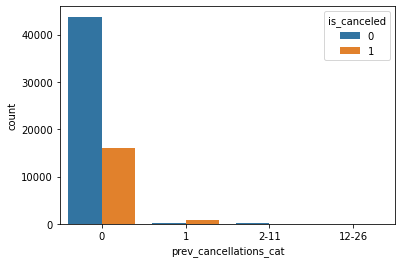

In [37]:
sns.countplot(x='prev_cancellations_cat', data=train_input_concat, hue='is_canceled')

In [38]:
train_input['prev_cancellations_cat'] = pd.cut(train_input['previous_cancellations'],
                                                    bins=[0,1,2,12,27], labels=['0', '1', '2-11', '12-26'],
                                                    right=False)
test_input['prev_cancellations_cat'] = pd.cut(test_input['previous_cancellations'],
                                                    bins=[0,1,2,12,27], labels=['0', '1', '2-11', '12-26'],
                                                    right=False)

In [39]:
print(train_input['prev_cancellations_cat'].value_counts())
print(test_input['prev_cancellations_cat'].value_counts())

0        59745
1          985
2-11       181
12-26        7
Name: prev_cancellations_cat, dtype: int64
0        25587
1          418
2-11        83
12-26        5
Name: prev_cancellations_cat, dtype: int64


In [40]:
train_input_concat.groupby(['is_canceled', 'deposit_type'])['deposit_type'].count().to_frame()

deposit_type
is_canceled deposit_type              
0           No Deposit           44076
            Non Refund              34
            Refundable              55
1           No Deposit           16048
            Non Refund             687
            Refundable              18

In [41]:
train_input_concat.groupby(['is_canceled', 'hotel', 'children'])['children'].count().to_frame()

children
is_canceled hotel        children          
0           City Hotel   0.0          23791
                         1.0           1405
                         2.0            768
                         3.0             24
            Resort Hotel 0.0          16662
                         1.0            896
                         2.0            605
                         3.0             14
1           City Hotel   0.0          10030
                         1.0            636
                         2.0            471
                         3.0              8
            Resort Hotel 0.0           4720
                         1.0            383
                         2.0            503
                         3.0              1
                         10.0             1

In [42]:
train_input_concat.groupby(['is_canceled', 'hotel', 'adults'])['adults'].count().to_frame()

adults
is_canceled hotel        adults        
0           City Hotel   1         5715
                         2        18282
                         3         1978
                         4           13
            Resort Hotel 1         3585
                         2        13849
                         3          731
                         4           12
1           City Hotel   1         1640
                         2         8333
                         3         1168
                         4            4
            Resort Hotel 1          614
                         2         4723
                         3          253
                         4            6
                         5            1
                         6            1
                         10           1
                         20           2
                         26           3
                         27           2
                         50           1
                         55           1

In [43]:
train_input_concat.groupby(['is_canceled', 'hotel', 'babies'])['babies'].count().to_frame()

babies
is_canceled hotel        babies        
0           City Hotel   0        25775
                         1          208
                         2            3
                         9            1
                         10           1
            Resort Hotel 0        17877
                         1          294
                         2            6
1           City Hotel   0        11105
                         1           40
            Resort Hotel 0         5540
                         1           66
                         2            2

**Nhận xét**: nếu người đặt yêu cầu nhiều chỗ trống để ô tô được đáp ứng thì khả năng họ sẽ không huỷ đặt chỗ.

In [44]:
train_input_concat['required_car_parking_spaces_cat'] = pd.cut(train_input_concat['required_car_parking_spaces'],
                                                    bins=[0,1,9], labels=['not_required', 'required'],
                                                    right=False)

<AxesSubplot:xlabel='required_car_parking_spaces_cat', ylabel='count'>

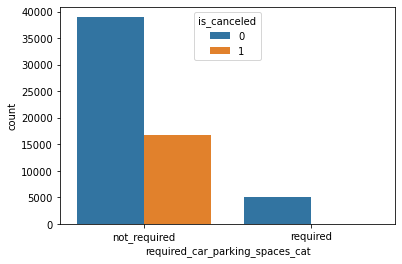

In [45]:
sns.countplot(x='required_car_parking_spaces_cat', data=train_input_concat, hue='is_canceled')

In [46]:
train_input['required_car_parking_spaces_cat'] = pd.cut(train_input['required_car_parking_spaces'],
                                                    bins=[0,1,9], labels=['not_required', 'required'],
                                                    right=False)
test_input['required_car_parking_spaces_cat'] = pd.cut(test_input['required_car_parking_spaces'],
                                                    bins=[0,1,9], labels=['not_required', 'required'],
                                                    right=False)

In [47]:
print(train_input['required_car_parking_spaces_cat'].value_counts())
print(test_input['required_car_parking_spaces_cat'].value_counts())

not_required    55772
required         5146
Name: required_car_parking_spaces_cat, dtype: int64
not_required    23935
required         2158
Name: required_car_parking_spaces_cat, dtype: int64


In [48]:
train_input_concat.groupby(['is_canceled', 'total_of_special_requests'])['total_of_special_requests'].count().to_frame()

total_of_special_requests
is_canceled total_of_special_requests                           
0           0                                              20494
            1                                              15706
            2                                               6383
            3                                               1345
            4                                                211
            5                                                 26
1           0                                              10141
            1                                               4544
            2                                               1773
            3                                                266
            4                                                 28
            5                                                  1

In [49]:
train_input_concat.groupby(['is_canceled', 'market_segment'], as_index=False)['lead_time'].mean()\
                    .sort_values(['is_canceled','lead_time'],ascending=False)

,is_canceled,market_segment,lead_time
11,1,Groups,182.074707
12,1,Offline TA/TO,133.438561
13,1,Online TA,103.095294
10,1,Direct,71.788157
9,1,Corporate,29.773481
8,1,Complementary,20.524590
7,1,Aviation,6.156250
14,1,Undefined,1.500000
4,0,Groups,133.241600
5,0,Offline TA/TO,102.242850


In [50]:
train_input_concat.groupby(['is_canceled', 'market_segment'], as_index=False)['adr'].sum()\
                    .sort_values(['is_canceled','adr'],ascending=False)

,is_canceled,market_segment,adr
13,1,Online TA,1588348.03
10,1,Direct,151834.50
12,1,Offline TA/TO,137798.26
11,1,Groups,70864.96
9,1,Corporate,28398.24
7,1,Aviation,3179.50
8,1,Complementary,76.83
14,1,Undefined,30.00
6,0,Online TA,2668058.02
3,0,Direct,808147.80


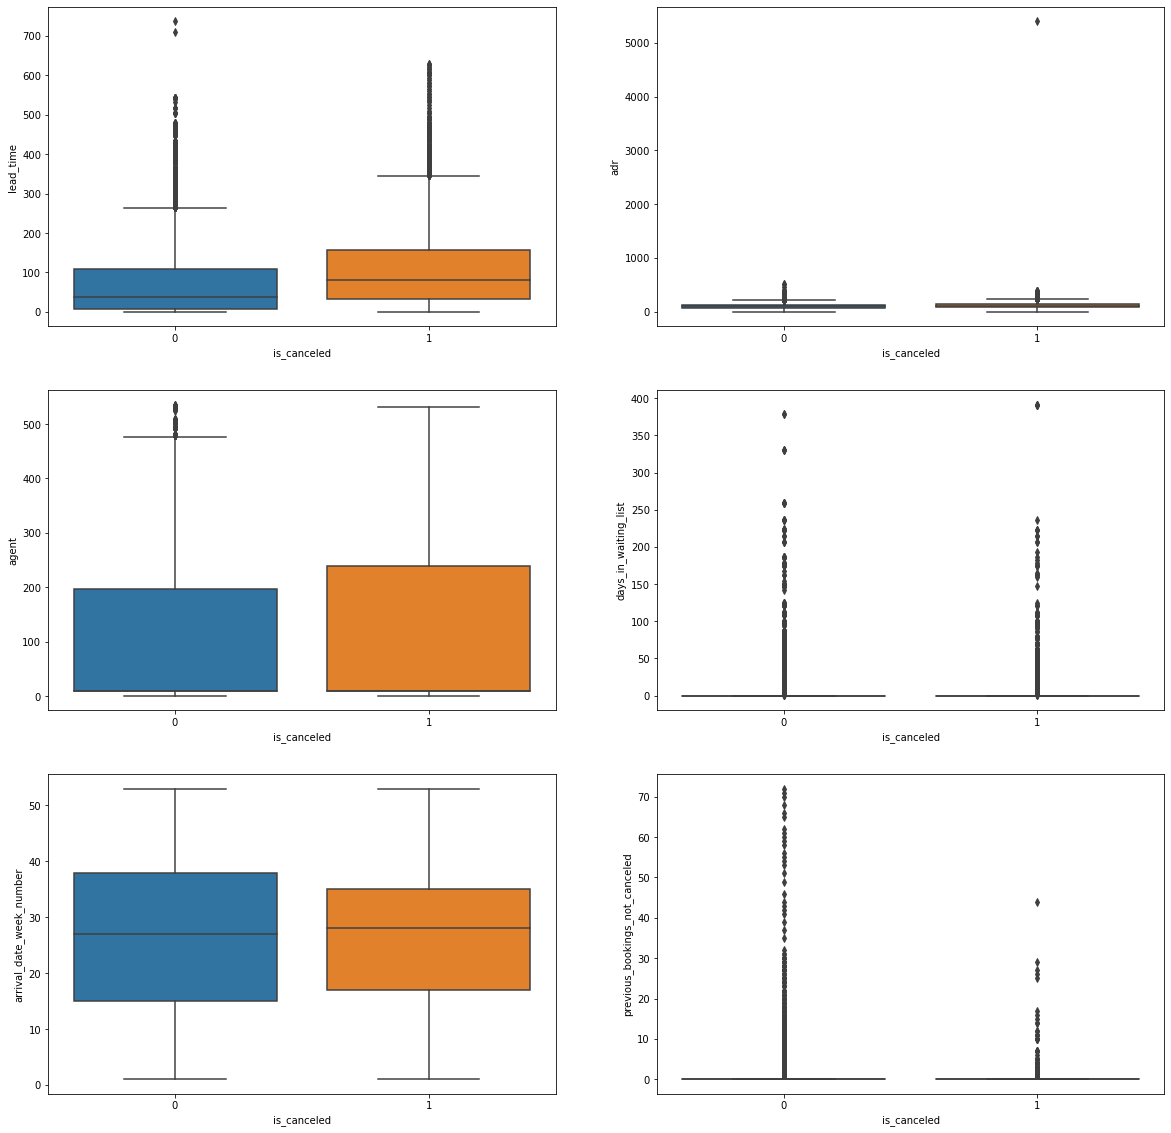

In [51]:
# Biểu đồ boxplot cho biết quan hệ giữa thuộc tính có kiểu numeric và thuộc tính 'hotel'
plt.figure(figsize=(20,20), facecolor='white')
plotnumber = 1
for feature in numerical_features:
    ax = plt.subplot(3,2,plotnumber)
    sns.boxplot(x='is_canceled', y= train_input_concat[feature], data=train_input_concat)
    plt.xlabel('is_canceled')
    plotnumber += 1
plt.show()

**Nhận xét**: với khoảng thời gian chờ từ ngày đặt đến ngày 

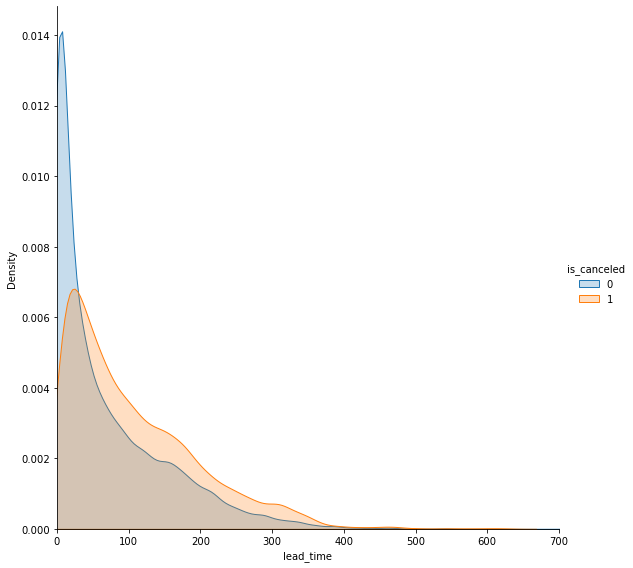

In [52]:
sns.FacetGrid(data=train_input_concat, hue = 'is_canceled',
             height = 8,
             xlim = (0,700)).map(sns.kdeplot, 'lead_time', shade = True).add_legend()

**Nhận xét:** khoảng thời gian chờ càng lâu (trên 50 ngày) thì khả năng huỷ đặt phòng cao hơn.

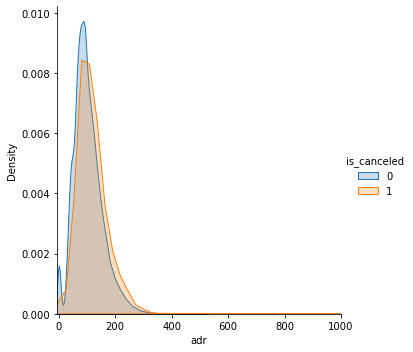

In [53]:
sns.FacetGrid(data=train_input_concat, hue = 'is_canceled',
             height = 5,
             xlim = (train_input_concat['adr'].min(),1000))\
.map(sns.kdeplot, 'adr', shade = True)\
.add_legend()

In [54]:
correlation = train_input_concat.corr()
correlation

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
lead_time,1.000000,0.143383,0.096018,0.006949,0.238560,0.314829,0.144335,0.019350,-0.006066,-0.146771,0.005519,-0.079015,0.082055,0.076329,0.133156,0.019275,-0.089980,0.034394,0.186821
arrival_date_year,0.143383,1.000000,-0.514446,-0.011285,0.007078,0.007081,0.036739,0.038881,-0.025709,0.023396,-0.054881,0.030035,0.011506,-0.003822,-0.027730,0.172761,-0.039846,0.062301,0.091448
arrival_date_week_number,0.096018,-0.514446,1.000000,0.096789,0.026354,0.025153,0.030487,0.015658,0.012004,-0.037784,0.006534,-0.023326,0.009039,0.017612,0.013028,0.096562,0.008527,0.047924,0.000384
arrival_date_day_of_month,0.006949,-0.011285,0.096789,1.000000,-0.016224,-0.027466,-0.000405,0.010834,-0.001595,-0.001759,-0.011321,-0.001068,0.007564,0.007497,0.009287,0.023983,0.011622,-0.000578,0.000819
stays_in_weekend_nights,0.238560,0.007078,0.026354,-0.016224,1.000000,0.552346,0.094463,0.025050,0.015789,-0.103830,-0.020676,-0.059849,0.037369,0.158749,-0.033687,0.038607,-0.043962,0.034470,0.063074
stays_in_week_nights,0.314829,0.007081,0.025153,-0.027466,0.552346,1.000000,0.099682,0.030180,0.014206,-0.112457,-0.020404,-0.059980,0.070859,0.191684,-0.000364,0.052113,-0.043973,0.040238,0.087260
adults,0.144335,0.036739,0.030487,-0.000405,0.094463,0.099682,1.000000,0.054331,0.014972,-0.168073,-0.043191,-0.122763,-0.032959,0.021002,-0.016332,0.230523,0.005206,0.114094,0.082767
children,0.019350,0.038881,0.015658,0.010834,0.025050,0.030180,0.054331,1.000000,0.016427,-0.046677,-0.019754,-0.029127,0.031394,0.047037,-0.020247,0.330893,0.040251,0.040212,0.062477
babies,-0.006066,-0.025709,0.012004,-0.001595,0.015789,0.014206,0.014972,0.016427,1.000000,-0.013349,-0.004927,-0.008839,0.077358,0.027277,-0.006557,0.021111,0.028722,0.091138,-0.021619
is_repeated_guest,-0.146771,0.023396,-0.037784,-0.001759,-0.103830,-0.112457,-0.168073,-0.046677,-0.013349,1.000000,0.214144,0.445252,0.008255,-0.056529,-0.013183,-0.146461,0.075771,0.000490,-0.089241


In [55]:
train_input.columns

Index(['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date',
       'prev_cancellations_cat', 'required_car_parking_spaces_cat'],
      dtype='object')

<a id='4'></a>
# 4. Tiền xử lý dữ liệu

In [56]:
# hotel_booking_cp['adults'] = hotel_booking_cp['adults'].astype('int64')
# hotel_booking_cp[hotel_booking_cp['adults'] > 4, 'adults'] = 4
#hotel_booking_cp['adults'].value_counts()

In [57]:
# hotel_booking_cp['booking_changes'].value_counts()

In [58]:
# hotel_booking.groupby(['is_canceled', 'stays_in_week_nights'])['stays_in_week_nights'].count().tail(60)

In [59]:
# hotel_booking.groupby(['is_canceled', 'stays_in_weekend_nights'])['stays_in_weekend_nights'].count()

In [60]:
# hotel_booking.loc[hotel_booking['stays_in_week_nights'].astype('int') >= 5] = 5

In [61]:
# hotel_booking.loc[hotel_booking['adults'] >= 4] = 4

### Xử lý dữ liệu outlier

In [62]:
# Xoá các quan sát có kết quả 'is_canceled' là 0 mà giá trị 'lead_time' trên 500
filtr = (train_output != 0) & (train_input['lead_time'] > 500)
train_input = train_input[~filtr]

# 
train_input = train_input[train_input['adr'] < 1000]
#
train_input = train_input[train_input['children'] < 10]
#
train_output = train_output[train_input.index]

print(f"input: {train_input.shape}")

input: (60885, 32)


In [63]:
num_features = ['stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies'\
                , 'arrival_date_week_number', 'lead_time', 'adr', 'booking_changes']
cat_features = ['hotel', 'country', 'arrival_date_year', 'arrival_date_month', 'meal'\
                , 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type'\
                ,'customer_type', 'deposit_type', 'prev_cancellations_cat'\
                , 'required_car_parking_spaces_cat']

feature_selection = num_features + cat_features
train_input = train_input[feature_selection]
test_input = test_input[feature_selection]

print(train_input.shape)
print(test_input.shape)

(60885, 22)
(26093, 22)


## Mã hoá các thuộc tính categorical

In [64]:
one_hot_features = ['hotel', 'country', 'arrival_date_year', 'arrival_date_month', 'meal'\
                    , 'distribution_channel', 'prev_cancellations_cat', 'required_car_parking_spaces_cat']
train_input = pd.get_dummies(train_input, prefix=one_hot_features, columns=one_hot_features)
test_input = pd.get_dummies(test_input, prefix=one_hot_features, columns=one_hot_features)

print(train_input.shape)
print(test_input.shape)

(60885, 60)
(26093, 60)


In [65]:
print(train_input.columns)
print(test_input.columns)

Index(['stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'arrival_date_week_number', 'lead_time', 'adr',
       'booking_changes', 'market_segment', 'reserved_room_type',
       'assigned_room_type', 'customer_type', 'deposit_type',
       'hotel_City Hotel', 'hotel_Resort Hotel', 'country_BEL', 'country_BRA',
       'country_CHE', 'country_DEU', 'country_ESP', 'country_FRA',
       'country_GBR', 'country_IRL', 'country_ITA', 'country_NLD',
       'country_Others', 'country_PRT', 'country_USA',
       'arrival_date_year_2015', 'arrival_date_year_2016',
       'arrival_date_year_2017', 'arrival_date_month_April',
       'arrival_date_month_August', 'arrival_date_month_December',
       'arrival_date_month_February', 'arrival_date_month_January',
       'arrival_date_month_July', 'arrival_date_month_June',
       'arrival_date_month_March', 'arrival_date_month_May',
       'arrival_date_month_November', 'arrival_date_month_October',
       'arriva

In [66]:
train_input.head()

,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,arrival_date_week_number,lead_time,adr,booking_changes,market_segment,...,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,prev_cancellations_cat_0,prev_cancellations_cat_1,prev_cancellations_cat_2-11,prev_cancellations_cat_12-26,required_car_parking_spaces_cat_not_required,required_car_parking_spaces_cat_required
91337,1,2,2,0.0,0,25,69,126.9,0,Online TA,...,0,0,1,0,1,0,0,0,1,0
102141,1,1,1,0.0,0,48,215,75.0,1,Groups,...,0,0,0,0,1,0,0,0,1,0
115126,0,3,2,0.0,0,26,125,95.7,0,Direct,...,1,0,0,0,1,0,0,0,1,0
107014,1,4,2,0.0,0,9,19,133.0,0,Direct,...,1,0,0,0,1,0,0,0,1,0
8531,0,5,1,0.0,0,41,65,70.0,0,Online TA,...,0,0,1,0,1,0,0,0,1,0


In [67]:
od_features = ['reserved_room_type', 'assigned_room_type', 'customer_type', 'deposit_type', 'market_segment']
for col in od_features:
    train_input[col] = train_input[col].astype('category').cat.codes
    test_input[col] = test_input[col].astype('category').cat.codes

print(train_input.shape)
print(test_input.shape)

(60885, 60)
(26093, 60)


<a id='5'></a>
# 5. Huấn luyện mô hình dự đoán

In [68]:
print(train_input.shape)
print(train_output.shape)
print(test_input.shape)
print(test_output.shape)

(60885, 60)
(60885,)
(26093, 60)
(26093,)


In [69]:
# Khởi tạo và huấn luyện mô hình
LogR_model = LogisticRegression()
LogR_model.fit(train_input, train_output)
# Dự đoán 
y_pred_LogR = LogR_model.predict(test_input)
# Xác định độ chính xác của mô hình
accuracy_LogG = accuracy_score(test_output, y_pred_LogR) 
print("Accuracy: %.2f%%" % (accuracy_LogG * 100.0))

Accuracy: 75.27%


In [70]:
# Khởi tạo và huấn luyện mô hình
DecTree_model = DecisionTreeClassifier()
DecTree_model.fit(train_input, train_output)

DecisionTreeClassifier()

In [71]:
std_slc = StandardScaler()

#pca = decomposition.PCA()

dec_tree = tree.DecisionTreeClassifier()

pipe = Pipeline(steps=[('std_slc', std_slc), ('dec_tree', dec_tree)])
# n_components = list(range(1,train_input.shape[1]+1,1))

criterion = ['gini', 'entropy']
max_depth = range(1, 13)

parameters = dict(dec_tree__criterion=criterion, dec_tree__max_depth=max_depth)
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(train_input, train_output)
print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print(); print(clf_GS.best_estimator_.get_params()['dec_tree'])
print(clf_GS.best_score_)

Best Criterion: gini
Best max_depth: 12

DecisionTreeClassifier(max_depth=12)
0.7786646957378665


In [74]:
# Xây dựng mô hình với thuật toán Random Forest Classifier
rd_clf = RandomForestClassifier()
rd_clf.fit(train_input, train_output)

y_pred_rd_clf = rd_clf.predict(test_input)

acc_rd_clf = accuracy_score(test_output, y_pred_rd_clf)
conf = confusion_matrix(test_output, y_pred_rd_clf)
clf_report = classification_report(test_output, y_pred_rd_clf)

print(f"Accuracy Score of Random Forest is : {acc_rd_clf}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Random Forest is : 0.8086459970106925
Confusion Matrix : 
[[17047  1871]
 [ 3122  4053]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.85      0.90      0.87     18918
           1       0.68      0.56      0.62      7175

    accuracy                           0.81     26093
   macro avg       0.76      0.73      0.75     26093
weighted avg       0.80      0.81      0.80     26093



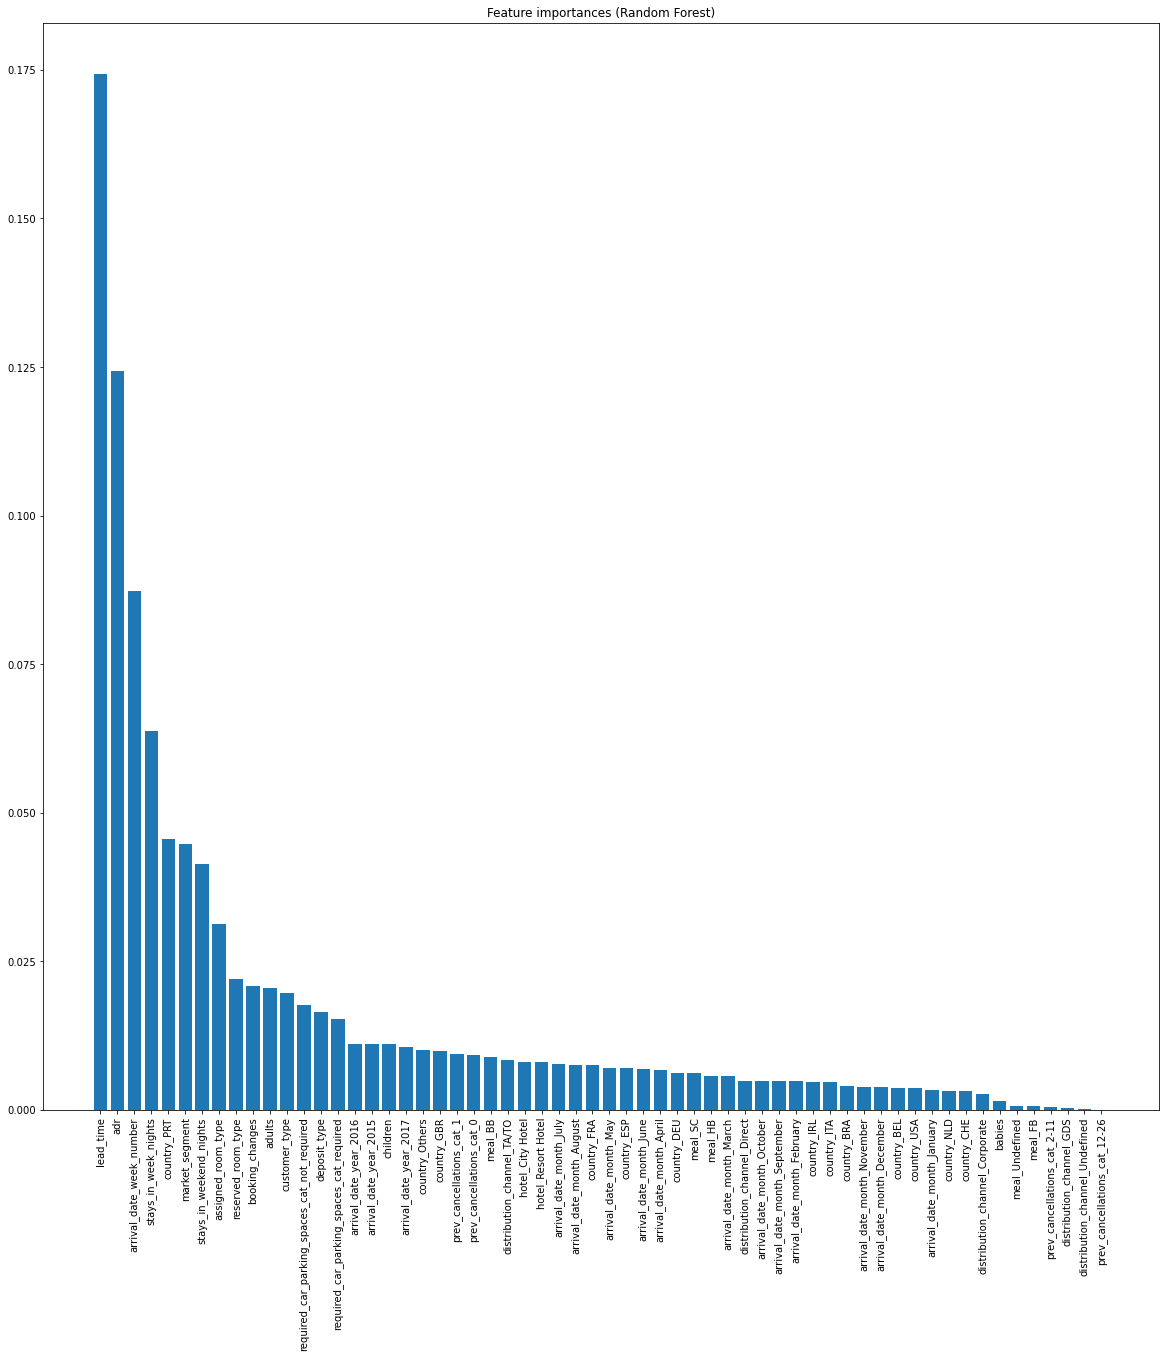

In [75]:
#Lấy ra các thuộc tính quan trọng từ model 
headers = ["name", "score"]
values = sorted(zip(train_input.columns, rd_clf.feature_importances_), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns = headers)

fig = plt.figure(figsize=(20,20))
x_pos = np.arange(0, len(feature_importances))
plt.bar(x_pos, feature_importances['score'], align='center')
plt.xticks(rotation=90)
plt.xticks(x_pos, feature_importances['name'])
plt.title('Feature importances (Random Forest)')

plt.show()

In [ ]:
feature_importances[feature_importances['score'] > 0.01]